In [1]:
from board3 import Board3
from controller3 import ActionController

import random

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from nnl import to_emb

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
def step(b, a, time=1600):
    bc = b.copy()
    nc = ActionController(bc)

    nc.execute_action(a)
    bc.step(time)

    reward = 0
    end = False
    if nc.is_win():
        reward = 1
        end = True
    elif nc.is_lose():
        reward = -1
        end = True
    elif nc.is_block():
        reward = -1
        end = True

    return bc, reward, end

def eval_net(net, n = 100, time_step=1600):
    net.eval()
    wins = 0
    loses = 0
    draws = 0

    for _ in range(n):
        b = Board3(walk_time=1000, walk_frodo=False)

        for _ in range(100):
            with torch.no_grad():
                vl = net(to_emb(b))

            act = vl.argmax().item()
            bc = b.copy()
            nc = ActionController(bc)

            nc.execute_action(act)
            bc.step(time_step)

            if nc.is_win():
                wins += 1
                break
            elif nc.is_lose():
                loses += 1
                break
            elif nc.is_block():
                loses += 1
                break
        else:
            draws += 1

    return wins / n, draws / n, loses / n


def eval_d(d, n = 100, time_step=1600):
    net.eval()
    wins = 0
    loses = 0
    draws = 0

    for _ in range(n):
        b = Board3(walk_time=1000, walk_frodo=False)

        for _ in range(100):

            act = max(range(ActionController.get_action_space()), key=lambda x: d[b][x])
            bc = b.copy()
            nc = ActionController(bc)

            nc.execute_action(act)
            bc.step(time_step)

            if nc.is_win():
                wins += 1
                break
            elif nc.is_lose():
                loses += 1
                break
            elif nc.is_block():
                loses += 1
                break
        else:
            draws += 1

    return wins / n, draws / n, loses / n

In [3]:
d = {}
epochs = 100000
for e in tqdm(range(epochs)):

    eps = min(0.8, 1 - e / epochs)

    b = Board3(walk_time=1000, walk_frodo=False)

    for _ in range(100):
        if b not in d:
            d[b] = [0.0 for _ in range(ActionController.get_action_space())]

        if random.random() < eps:
            act = random.randint(0, ActionController.get_action_space() - 1)
        else:
            act = max(range(ActionController.get_action_space()), key=lambda x: d[b][x])

        bc, reward, end = step(b, act, 1600)

        if end:
            nt = reward
        else:
            if bc not in d:
                d[bc] = [0.0 for _ in range(ActionController.get_action_space())]
            nt = reward + 0.9 * max(d[bc])

        d[b][act] = d[b][act] + 0.1 * (nt - d[b][act])

        if end:
            break
        b = bc




  0%|          | 0/100000 [00:00<?, ?it/s]

In [4]:
print(len(d))
b = Board3(walk_time=1000, walk_frodo=False)
b.players_positions = [(2, 1), (0, 0), (3, 3)]
print(b)
print(d[b])
print(ActionController.explain_action(max(range(ActionController.get_action_space()), key=lambda x: d[b][x])))

1173126
E  %  .  %
.  %  .  %
.  P  .  .
.  .  .  T
[0.5902683764263933, 0.5425962506786192, 0.6687092647359166, 0.6275761470612395, 0.5811791016283341, 0.7325821394630192, 0.3377980966516734, 0.899999999999999, 0.7451792716605272, 0.02215369751194752, 0.034528495235954304, 0.01763758017393626, 0.014537685704157147, 0.02058024429289468, 0.04890368346226694, 0.05033923633601084, 0.03312494032692697, 0.054830245901409204, 0.028124318708347692, 0.01407820380041701, 0.025104044601782362, 0.7257766268579254, 0.776717437224298, 0.6034856507948609, 0.4783690346872167, 0.6874247310745855, 0.6539568453610957, 0.7106195234659124, 0.7941088679053511, -0.7941088679053511, 0.0018471359121115946, 0.21260497273896162, 0.0, 0.0, 0.0008100000000000002, 0.0, 0.0, 0.14882505369712423]
Move 1 -1


In [162]:
bds = []
vls = []

for k, v in tqdm(d.items()):
    bds.append(to_emb(k))
    vls.append(v)

fv = torch.Tensor(vls)
fv = (fv - fv.mean()) / (fv.std() + 1e-8)

data = TensorDataset(torch.cat(bds, dim=0), fv)

  0%|          | 0/526168 [00:00<?, ?it/s]

In [201]:
class Net(nn.Module):
    def __init__(self, n_input, n_actions):
        super(Net, self).__init__()
        self.seq = nn.Sequential(
            # nn.BatchNorm1d(n_input),
            nn.Linear(n_input, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, n_actions),
            # nn.Tanh()
        )

    def forward(self, x):
        return self.seq(x)

net = Net(to_emb(Board3()).shape[1], ActionController.get_action_space())


def train_net(net, data, show_progress=False):
    opt = optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    lh = []

    epochs = 12

    if show_progress:
        progress = tqdm(total=len(data) * epochs)

    for _ in range(epochs):
        el = []
        for b, v in DataLoader(data, batch_size=32, shuffle=True):
            opt.zero_grad()
            vl = net(b)
            loss = criterion(vl, v)
            loss.backward()
            opt.step()
            el.append(loss.item())
            if show_progress:
                progress.update(b.shape[0])
        lh.append(sum(el) / len(el))

    if show_progress:
        progress.close()
        plt.plot(lh)
        plt.show()

train_net(net, data, show_progress=True)
print(eval_net(net))


  0%|          | 0/6314016 [00:00<?, ?it/s]

KeyboardInterrupt: 

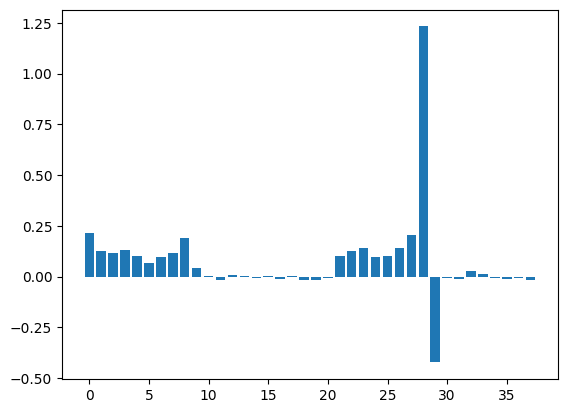

tensor(28)


In [199]:
b = Board3(walk_time=1000, walk_frodo=False)
b.players_positions = [(2, 1), (0, 0), (3, 3)]
net.eval()
with torch.no_grad():
    vl = net(to_emb(b))

plt.bar(range(ActionController.get_action_space()), vl.squeeze(0))
plt.show()
print(vl.argmax())

In [194]:


eval_net(net)


(0.19, 0.81, 0.0)

In [195]:


eval_d(d, 100, 1600)

(0.09, 0.91, 0.0)